# Contents:

[Background and Objective](#Background)

[Import and Warehouse data](#Data_Import)

[Data Cleansing](#Data_Cleansing)

[Data Analysis & Visualisation](#Analysis_Visualisation)

[Data Pre-processing](#Pre-processing)

[Model Training, Testing and Tuning](#Model)

[Conclusion and Improvisation](#Conclusion)


<a id='the_destination'></a>


<a id='Background'></a>

# Background and Objective

• **DOMAIN:** Banking and finance


• **CONTEXT:** A bank X is on a massive digital transformation for all its departments. Bank has a growing customer base where
majority of them are liability customers (depositors) vs borrowers (asset customers). The bank is interested in expanding the
borrowers base rapidly to bring in more business via loan interests. A campaign that the bank ran in last quarter showed an
average single digit conversion rate. Digital transformation being the core strength of the business strategy, marketing
department wants to devise effective campaigns with better target marketing to increase the conversion ratio to double digit
with same budget as per last campaign.


• **DATA DESCRIPTION:** The data consists of the following attributes:
1. ID: Customer ID
2. Age Customer’s approximate age.
3. CustomerSince: Customer of the bank since. [unit is masked]
4. HighestSpend: Customer’s highest spend so far in one transaction. [unit is masked]
5. ZipCode: Customer’s zip code.
6. HiddenScore: A score associated to the customer which is masked by the bank as an IP.
7. MonthlyAverageSpend: Customer’s monthly average spend so far. [unit is masked]
8. Level: A level associated to the customer which is masked by the bank as an IP.
9. Mortgage: Customer’s mortgage. [unit is masked]
10. Security: Customer’s security asset with the bank. [unit is masked]
11. FixedDepositAccount: Customer’s fixed deposit account with the bank. [unit is masked]
12. InternetBanking: if the customer uses internet banking.
13. CreditCard: if the customer uses bank’s credit card.
14. LoanOnCard: if the customer has a loan on credit card.


• **PROJECT OBJECTIVE:** Build an AIML model to perform focused marketing by predicting the potential customers who will
convert using the historical dataset.

In [1]:
import numpy as np
import pandas as pd

# To enable plotting graphs in Jupyter notebook
%matplotlib inline 

import seaborn as sns
import matplotlib.pyplot as plt

# Import stats and sklearn

import statsmodels.api as sm

from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from scipy.stats import zscore


# Import Lasso and Ridge

from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

from sklearn.utils import resample

# Import Naive Bayes

from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
   

# To see multiple outputs together

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

<a id='Data_Import'></a>

# Import and Warehouse Data

#### Import and Dimension Check Individual Data-sets

In [2]:
# Read data

data1 = pd.read_csv('Part2 - Data1.csv')
data2 = pd.read_csv('Part2 -Data2.csv')



In [3]:
# Using head() to display few rows

data1.head(2)
data2.head(2)

,ID,Age,CustomerSince,HighestSpend,ZipCode,HiddenScore,MonthlyAverageSpend,Level
0,1,25,1,49,91107,4,1.6,1
1,2,45,19,34,90089,3,1.5,1


,ID,Mortgage,Security,FixedDepositAccount,InternetBanking,CreditCard,LoanOnCard
0,1,0,1,0,0,0,NaN
1,2,0,1,0,0,0,NaN


In [4]:
# Shape and size of each data

print("Data1 has {} rows / observations and {} columns / features".format(data1.shape[0],data1.shape[1]))
print()
print("Data2 has {} rows / observations and {} columns / features".format(data2.shape[0],data2.shape[1]))


Data1 has 5000 rows / observations and 8 columns / features

Data2 has 5000 rows / observations and 7 columns / features


In [5]:
# Checking on unique ids

data1.ID.nunique()
data2.ID.nunique()

5000

5000

Both the data-sets have 5000 unique ids and we move ahead with an inner join to merge the two data-sets using ID as the key variable.

#### Merge and Explore Shape of Final Data

In [6]:
# Merging two datasets

df = pd.merge(data1, data2, on='ID',how='inner')


In [7]:
print("Final has {} rows / observations and {} columns / features".format(df.shape[0],df.shape[1]))

Final has 5000 rows / observations and 14 columns / features


<a id='Data_Cleansing'></a>

# Data Cleansing

#### Data-types of features

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   5000 non-null   int64  
 1   Age                  5000 non-null   int64  
 2   CustomerSince        5000 non-null   int64  
 3   HighestSpend         5000 non-null   int64  
 4   ZipCode              5000 non-null   int64  
 5   HiddenScore          5000 non-null   int64  
 6   MonthlyAverageSpend  5000 non-null   float64
 7   Level                5000 non-null   int64  
 8   Mortgage             5000 non-null   int64  
 9   Security             5000 non-null   int64  
 10  FixedDepositAccount  5000 non-null   int64  
 11  InternetBanking      5000 non-null   int64  
 12  CreditCard           5000 non-null   int64  
 13  LoanOnCard           4980 non-null   float64
dtypes: float64(2), int64(12)
memory usage: 585.9 KB


* There are 20 missing values for the target feature "LoanOnCard".
* We will decide on treatment of these missing values after exploring more on the distribution of this feature.
* Other features do not have any missing values.

Now, we look into the data-types of each attributes.

* ZipCode is expressed as an integer. Though it is expressed by numbers ZipCode is actually a nominal variable which can provide information on location. Hence it is better to convert it to object type.

* Features like Internet Banking, Security, Fixed Deposit, Credit Card etc are binary variables. For now we keep them as int64 type. Later, if required for analysis we may use conversions.

#### Missing value imputation for "LoanOnCard"

We first look into the frequency distribution of the attribute. This will help us to identify the mode and decide on the missing value treatment.

In [9]:
#Frequency distribution for Target

df.LoanOnCard.value_counts()

0.0    4500
1.0     480
Name: LoanOnCard, dtype: int64

- The frequency distribution of the target variable shows that the data is highly imbalanced. Also, the missing values have been treated as 0s through the frequency distribution.
- Usually, for missing value imputation for categorical variable we use the mode. In this case, imputing missing values with mode will make the data more imbalanced.
- Another way to impute missing values could be to use statistical modelling techniques, example classification techniques to identify the missing values of the class variable.
- However, due to the high imbalance in data imputing through modelling technique may not be a good option.
- Since, 20 out of 5000, i.e. only 0.4% of the data is missing - the best situation here is to drop those rows. This may lead to loss of information. However, given that percentage is very low we proceed with dropping those rows.
- We will also drop "ID" and "ZipCode" variable since they are more like identification variable.

In [10]:
# Dropping the rows with missing values and ID and ZipCode Columns

df.dropna(inplace=True)
df.drop(['ID','ZipCode'],
  axis='columns', inplace=True)

In [11]:
# Verifying the shape and data-types post missing value treatment

df.shape
df.info()



(4980, 12)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4980 entries, 9 to 4999
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Age                  4980 non-null   int64  
 1   CustomerSince        4980 non-null   int64  
 2   HighestSpend         4980 non-null   int64  
 3   HiddenScore          4980 non-null   int64  
 4   MonthlyAverageSpend  4980 non-null   float64
 5   Level                4980 non-null   int64  
 6   Mortgage             4980 non-null   int64  
 7   Security             4980 non-null   int64  
 8   FixedDepositAccount  4980 non-null   int64  
 9   InternetBanking      4980 non-null   int64  
 10  CreditCard           4980 non-null   int64  
 11  LoanOnCard           4980 non-null   float64
dtypes: float64(2), int64(10)
memory usage: 505.8 KB


<a id='Analysis_Visualisation'></a>

# Data Analysis & Visualisation

In [12]:
# 5 point Summary of the attributes

df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Age,4980.0,45.352610,11.464212,23.0,35.0,45.0,55.000,67.0
CustomerSince,4980.0,20.117671,11.468716,-3.0,10.0,20.0,30.000,43.0
HighestSpend,4980.0,73.852410,46.070090,8.0,39.0,64.0,98.000,224.0
HiddenScore,4980.0,2.395582,1.147200,1.0,1.0,2.0,3.000,4.0
MonthlyAverageSpend,4980.0,1.939536,1.750006,0.0,0.7,1.5,2.525,10.0
Level,4980.0,1.880924,0.840144,1.0,1.0,2.0,3.000,3.0
Mortgage,4980.0,56.589759,101.836758,0.0,0.0,0.0,101.000,635.0
Security,4980.0,0.104418,0.305832,0.0,0.0,0.0,0.000,1.0
FixedDepositAccount,4980.0,0.060643,0.238697,0.0,0.0,0.0,0.000,1.0
InternetBanking,4980.0,0.597189,0.490513,0.0,0.0,1.0,1.000,1.0


* The average age of the customers is 45 years and the age ranges between 23 to 67. The equality of mean and standard deviation suggests the distribution is either normal or uniform.
* We do not have any unit for CustomerSince. However the minimum negative value indicates presence of incorrect data as timeline could not be negative. Assuming that the negative sign has been by mistake we will convert it to positive.
* HiddenScore and Level seem to be categorical variables with 4 and 3 classes respectively. However, for both we are not sure of the order.
* HighestSpend, MonthlyAverageSpend appear to be postively skewed with mean greater than median.
* MonthlyAverageSpend has minimum value of 0 which is unlikely. Hence we will assume them to be missing values and replace with mean.
* Median of Mortgage is 0, suggests more than 50% of the customers do not have any mortgage. We will look into the distribution of Mortgage to decide further on this feature.

In [13]:
# Replacing Negative Timeline value by Positive Timeline value

df.loc[df['CustomerSince'] < 0, 'CustomerSince'] = -(df.CustomerSince)
df.loc[df['MonthlyAverageSpend'] == 0, 'MonthlyAverageSpend'] = np.mean(df.MonthlyAverageSpend)
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Age,4980.0,45.352610,11.464212,23.0,35.0,45.0,55.000,67.0
CustomerSince,4980.0,20.147390,11.416417,0.0,10.0,20.0,30.000,43.0
HighestSpend,4980.0,73.852410,46.070090,8.0,39.0,64.0,98.000,224.0
HiddenScore,4980.0,2.395582,1.147200,1.0,1.0,2.0,3.000,4.0
MonthlyAverageSpend,4980.0,1.980819,1.726479,0.1,0.7,1.6,2.525,10.0
Level,4980.0,1.880924,0.840144,1.0,1.0,2.0,3.000,3.0
Mortgage,4980.0,56.589759,101.836758,0.0,0.0,0.0,101.000,635.0
Security,4980.0,0.104418,0.305832,0.0,0.0,0.0,0.000,1.0
FixedDepositAccount,4980.0,0.060643,0.238697,0.0,0.0,0.0,0.000,1.0
InternetBanking,4980.0,0.597189,0.490513,0.0,0.0,1.0,1.000,1.0


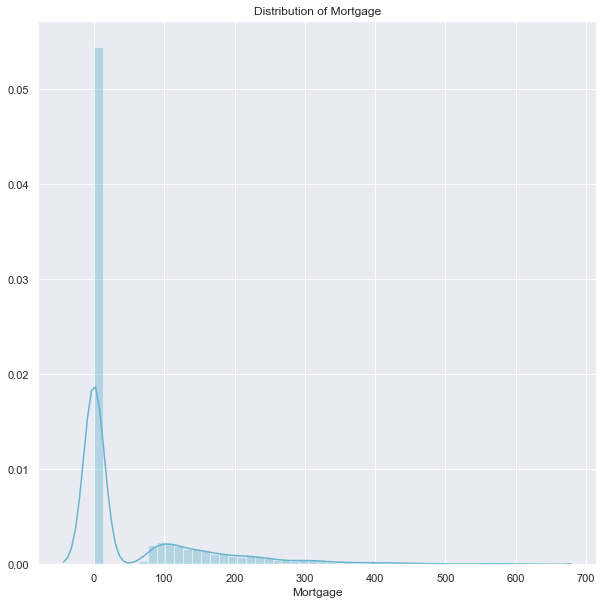

In [14]:
# Distribution of Mortgage

sns.set(rc={"figure.figsize": (10, 10)});
ax=sns.distplot(df.Mortgage, color='c');
ax.set_title('Distribution of Mortgage');


* Majority of the customers do not have a Mortgage. Hence exact mortgage amount of few customers may not add much value to the modelling. Instead of dropping the feature, we can use it as a binary variable with 0 indicating no mortgage and 1 indicating mortgage.

##### For the numeric variables we check for outliers.

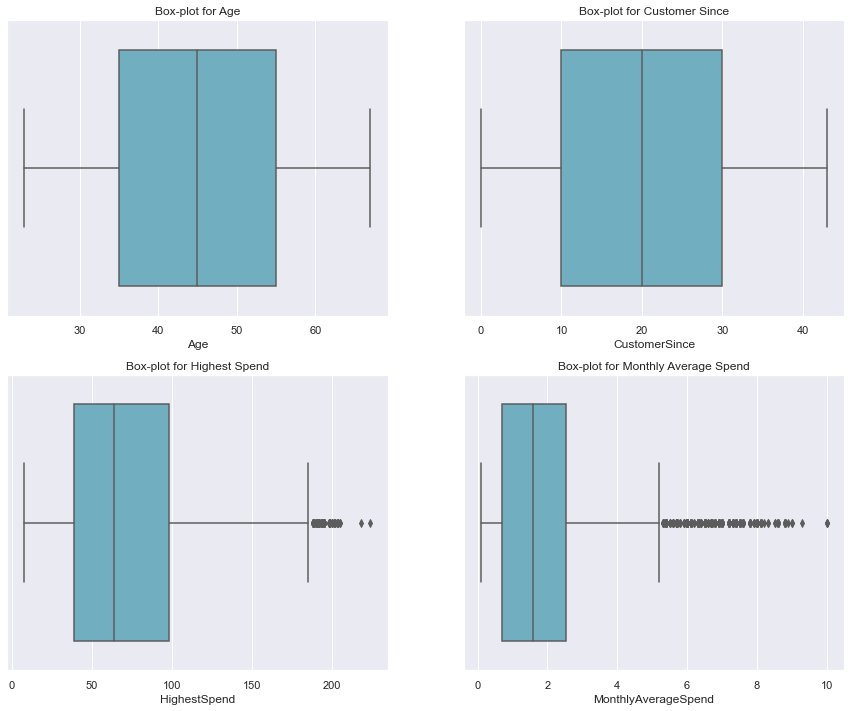

In [15]:
# Box-plot to visualise outliers and distribution of numeric variables

sns.set(rc={"figure.figsize": (15, 25)});

plt.subplot(4,2,1);
sns.boxplot(df['Age'],color='c');
plt.title('Box-plot for Age');

plt.subplot(4,2,2);
sns.boxplot(df['CustomerSince'],color='c');
plt.title('Box-plot for Customer Since');

plt.subplot(4,2,3);
sns.boxplot(df['HighestSpend'],color='c');
plt.title('Box-plot for Highest Spend');


plt.subplot(4,2,4);
sns.boxplot(df['MonthlyAverageSpend'],color='c');
plt.title('Box-plot for Monthly Average Spend');



* There's presence of notable number of outliers for both Highest Spend and Monthly Average Spend. Since both Logistic Regression and Naive Bayes are sensitive to outliers we do an outlier treatment.

In [16]:
# Calculating IQR Replacing outliers in HighestSpend and MonthlyAverageSpend by upper whisker

# For Highest Spend

df1 = df.copy()

Q1_HS = df1.HighestSpend.quantile(0.25)
Q3_HS = df1.HighestSpend.quantile(0.75)
IQR_HS = Q3_HS - Q1_HS


df1.loc[df1['HighestSpend'] > Q3_HS+1.5*IQR_HS, 'HighestSpend'] = Q3_HS+1.5*IQR_HS

# For Average Spend

Q1_AS = df1.MonthlyAverageSpend.quantile(0.25)
Q3_AS = df1.MonthlyAverageSpend.quantile(0.75)
IQR_AS = Q3_AS - Q1_AS


df1.loc[df1['MonthlyAverageSpend'] > Q3_AS+1.5*IQR_AS, 'MonthlyAverageSpend'] = Q3_AS+1.5*IQR_AS



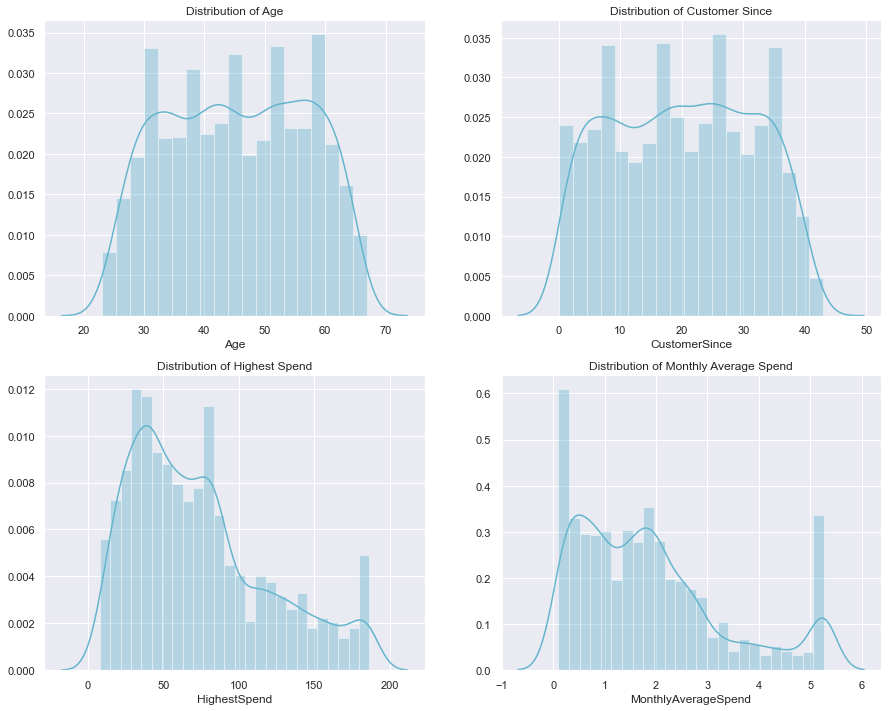

In [17]:
# Checking the distributions of the numeric faetures

sns.set(rc={"figure.figsize": (15, 25)});

plt.subplot(4,2,1);
ax=sns.distplot(df1.Age, color='c');
ax.set_title('Distribution of Age');


plt.subplot(4,2,2);
ax=sns.distplot(df1.CustomerSince, color='c');
ax.set_title('Distribution of Customer Since');

plt.subplot(4,2,3);
ax=sns.distplot(df1.HighestSpend, color='c');
ax.set_title('Distribution of Highest Spend');

plt.subplot(4,2,4);
ax=sns.distplot(df1.MonthlyAverageSpend, color='c');
ax.set_title('Distribution of Monthly Average Spend');



* Age and Customer Since follows Uniform multi-modal distribution
* Highest Spend and Monthly Average Spend are positively skewed multi-modal distribution

In [18]:
# Converting Mortgage to binary

df1.loc[df['Mortgage'] == 0, 'MortgageStatus'] = 0
df1.loc[df['Mortgage'] >0, 'MortgageStatus'] = 1
df1.drop('Mortgage', axis=1, inplace=True)

In [19]:
# Checking on 5-point summary after some data corrections

df1.describe().transpose()

df1.info()

,count,mean,std,min,25%,50%,75%,max
Age,4980.0,45.352610,11.464212,23.0,35.0,45.0,55.000,67.0000
CustomerSince,4980.0,20.147390,11.416417,0.0,10.0,20.0,30.000,43.0000
HighestSpend,4980.0,73.694980,45.661432,8.0,39.0,64.0,98.000,186.5000
HiddenScore,4980.0,2.395582,1.147200,1.0,1.0,2.0,3.000,4.0000
MonthlyAverageSpend,4980.0,1.877858,1.438047,0.1,0.7,1.6,2.525,5.2625
Level,4980.0,1.880924,0.840144,1.0,1.0,2.0,3.000,3.0000
Security,4980.0,0.104418,0.305832,0.0,0.0,0.0,0.000,1.0000
FixedDepositAccount,4980.0,0.060643,0.238697,0.0,0.0,0.0,0.000,1.0000
InternetBanking,4980.0,0.597189,0.490513,0.0,0.0,1.0,1.000,1.0000
CreditCard,4980.0,0.294378,0.455808,0.0,0.0,0.0,1.000,1.0000


<class 'pandas.core.frame.DataFrame'>
Int64Index: 4980 entries, 9 to 4999
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Age                  4980 non-null   int64  
 1   CustomerSince        4980 non-null   int64  
 2   HighestSpend         4980 non-null   float64
 3   HiddenScore          4980 non-null   int64  
 4   MonthlyAverageSpend  4980 non-null   float64
 5   Level                4980 non-null   int64  
 6   Security             4980 non-null   int64  
 7   FixedDepositAccount  4980 non-null   int64  
 8   InternetBanking      4980 non-null   int64  
 9   CreditCard           4980 non-null   int64  
 10  LoanOnCard           4980 non-null   float64
 11  MortgageStatus       4980 non-null   float64
dtypes: float64(4), int64(8)
memory usage: 505.8 KB


In [20]:
# Function to add percentage values to chart

def add_percentage(plot, feature):
    total = len(feature)
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y))
    plt.show();

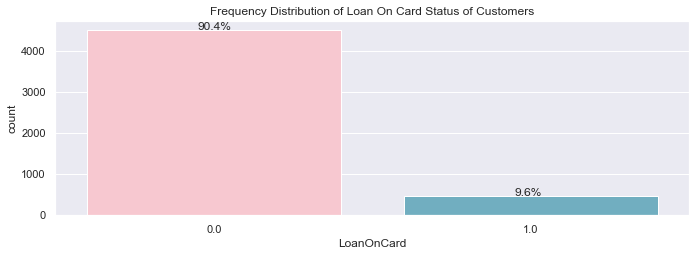

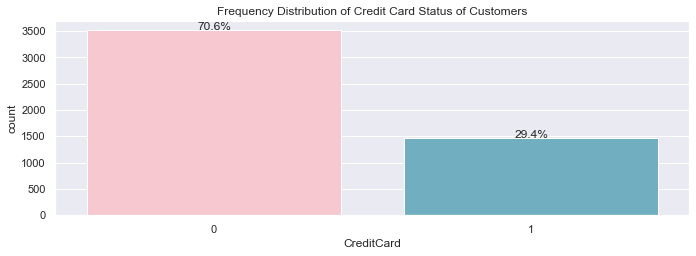

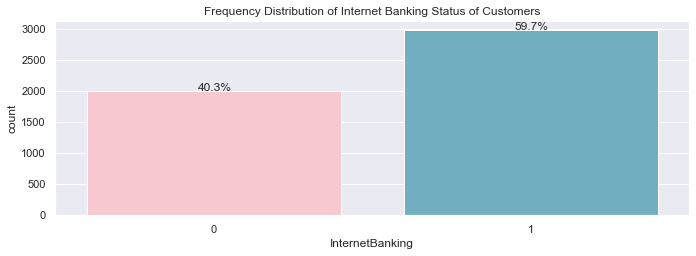

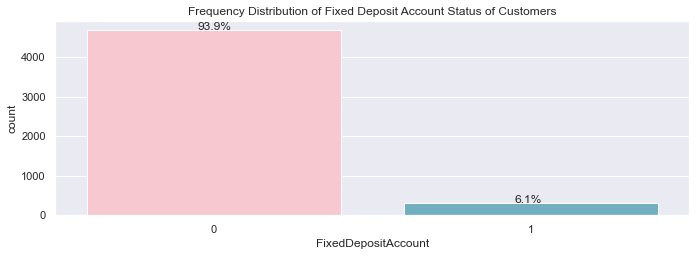

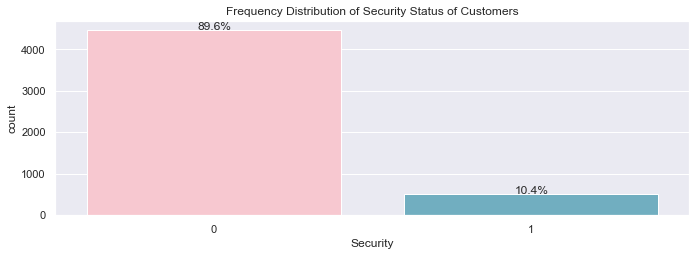

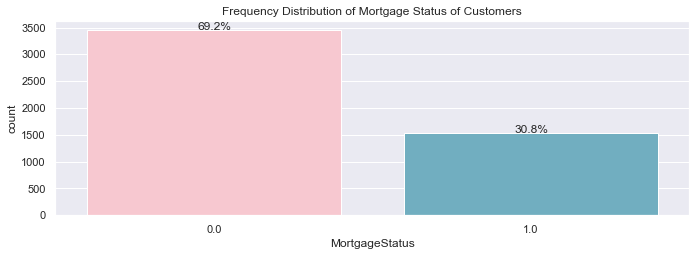

In [21]:
sns.set(rc={"figure.figsize": (25, 25)});

plt.subplot(6,2,1);
ax=sns.countplot(df1['LoanOnCard'],palette=['Pink','c']);
plt.title('Frequency Distribution of Loan On Card Status of Customers');
add_percentage(ax,df1.LoanOnCard);

plt.subplot(6,2,2);
ax=sns.countplot(df1['CreditCard'],palette=['Pink','c']);
plt.title('Frequency Distribution of Credit Card Status of Customers');
add_percentage(ax,df1.CreditCard);

plt.subplot(6,2,3);
ax=sns.countplot(df1['InternetBanking'],palette=['Pink','c']);
plt.title('Frequency Distribution of Internet Banking Status of Customers');
add_percentage(ax,df1.InternetBanking);

plt.subplot(6,2,4);
ax=sns.countplot(df1['FixedDepositAccount'],palette=['Pink','c']);
plt.title('Frequency Distribution of Fixed Deposit Account Status of Customers');
add_percentage(ax,df1.FixedDepositAccount);


plt.subplot(6,2,5);
ax=sns.countplot(df1['Security'],palette=['Pink','c']);
plt.title('Frequency Distribution of Security Status of Customers');
add_percentage(ax,df1.Security);


plt.subplot(6,2,6);
ax=sns.countplot(df1['MortgageStatus'],palette=['Pink','c']);
plt.title('Frequency Distribution of Mortgage Status of Customers');
add_percentage(ax,df1.MortgageStatus);




* Only around 10% customers have a loan on credit card (target)
* Around 30% of customers have a credit card.
* Around 60% of customers use Internet Banking.
* Only 6% of customers have a Fixed Deposit Account.
* Only 10% of customers have a Security with bank.
* Around 31% of customers have a Mortgage.

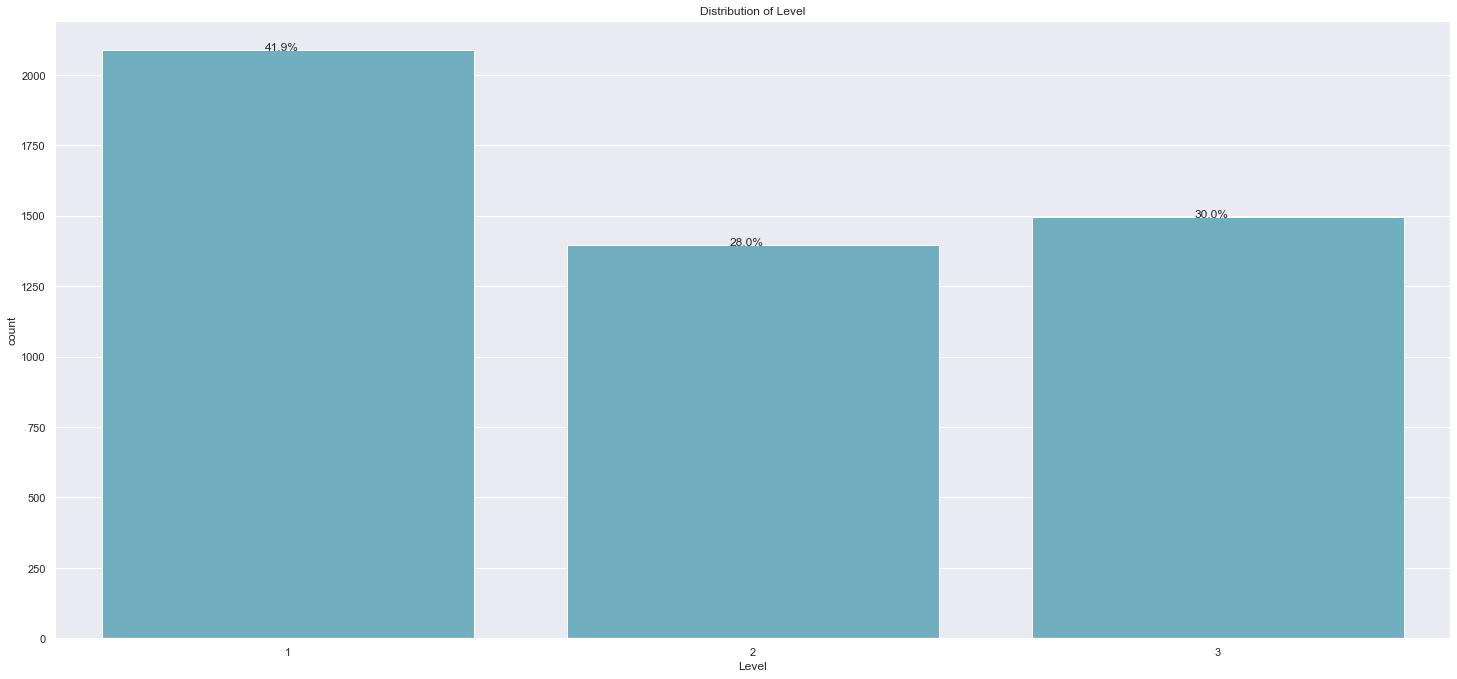

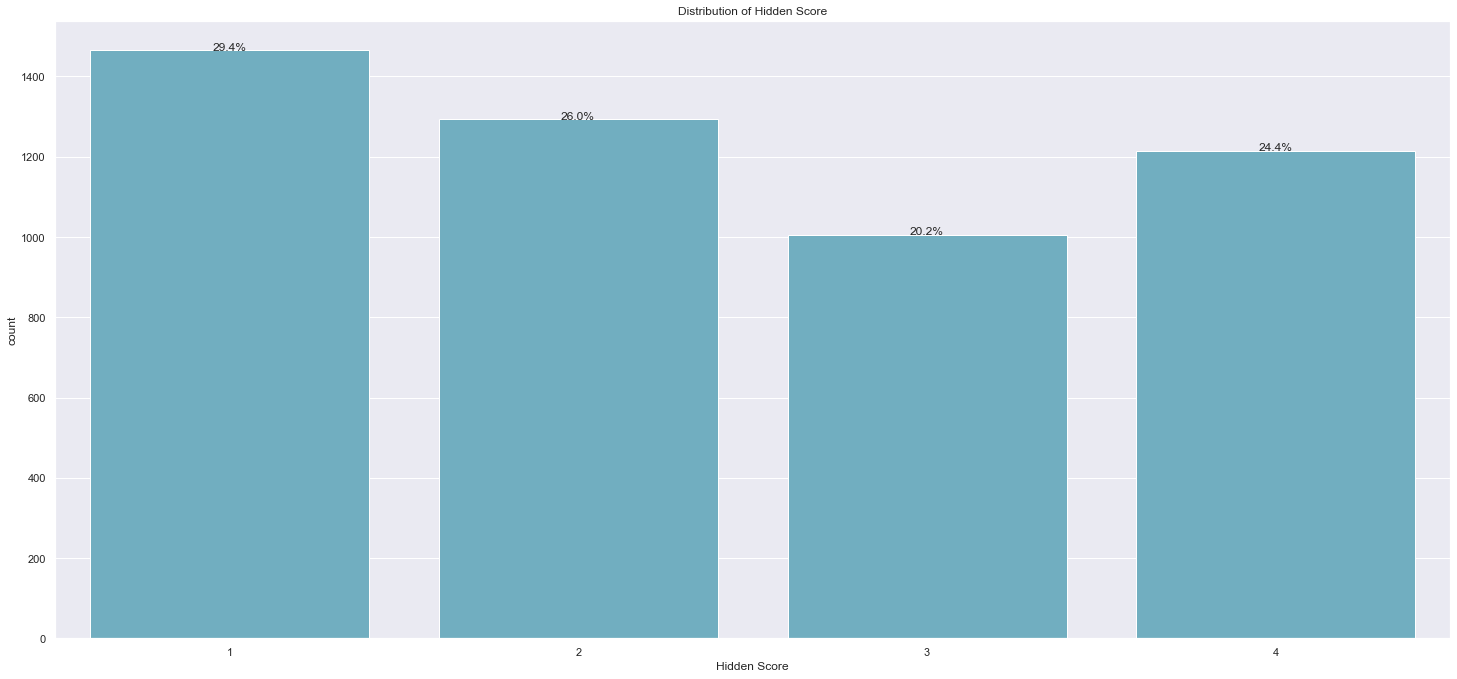

In [22]:
plt.subplot(2,1,1);
ax=sns.countplot(df1["Level"], color='c');
plt.xlabel('Level');
plt.title('Distribution of Level');
add_percentage(ax,df1.Level);

plt.subplot(2,1,2);
ax=sns.countplot(df1["HiddenScore"], color='c');
plt.xlabel('Hidden Score');
plt.title('Distribution of Hidden Score');
add_percentage(ax,df1.HiddenScore);



* 42% customers are in Level 1, 30% in Level 3 and 28% Level 2.
* Percentage of customers in the 4 Score buckets are more-or-less uniform, 29% customers (highest) have Score 1 and 20% (lowest) have Score 3.

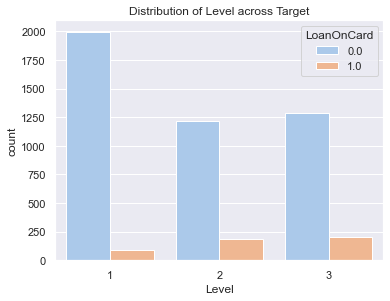

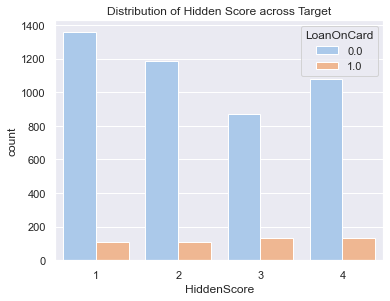

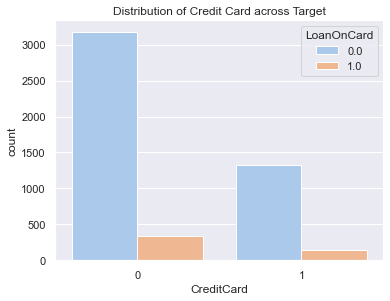

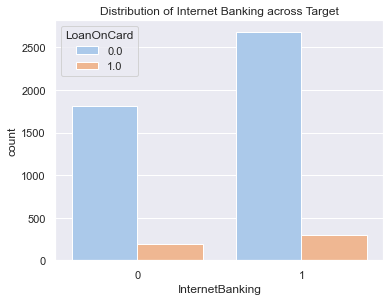

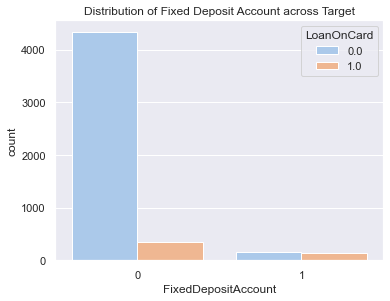

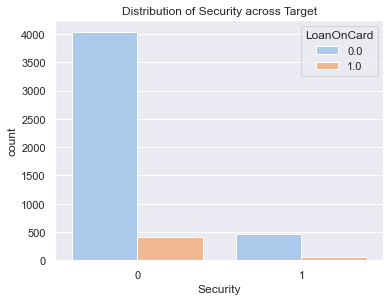

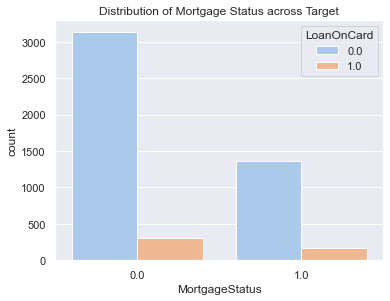

In [23]:
#Analysis between Target Variable and Other categorical variables


plt.figure(figsize= (20,15));
plt.subplot(3,3,1);
ax=sns.countplot(df1["Level"],palette="pastel",hue=df1["LoanOnCard"]);
plt.title('Distribution of Level across Target');


plt.figure(figsize= (20,15));
plt.subplot(3,3,2);
ax=sns.countplot(df1["HiddenScore"],palette="pastel",hue=df1["LoanOnCard"]);
plt.title('Distribution of Hidden Score across Target');


plt.figure(figsize= (20,15));
plt.subplot(3,3,3);
ax=sns.countplot(df1["CreditCard"],palette="pastel",hue=df1["LoanOnCard"]);
plt.title('Distribution of Credit Card across Target');



plt.figure(figsize= (20,15));
plt.subplot(3,3,4);
ax=sns.countplot(df1["InternetBanking"],palette="pastel",hue=df1["LoanOnCard"]);
plt.title('Distribution of Internet Banking across Target');


plt.figure(figsize= (20,15));
plt.subplot(3,3,5);
ax=sns.countplot(df1["FixedDepositAccount"],palette="pastel",hue=df1["LoanOnCard"]);
plt.title('Distribution of Fixed Deposit Account across Target');



plt.figure(figsize= (20,15));
plt.subplot(3,3,6);
ax=sns.countplot(df1["Security"],palette="pastel",hue=df1["LoanOnCard"]);
plt.title('Distribution of Security across Target');


plt.figure(figsize= (20,15));
plt.subplot(3,3,7);
ax=sns.countplot(df1["MortgageStatus"],palette="pastel",hue=df1["LoanOnCard"]);
plt.title('Distribution of Mortgage Status across Target');





* There are few customers who do not have credit card but have a loan on the card. These seem to be erroneous data. We will check what percentage of total customer have this feature.

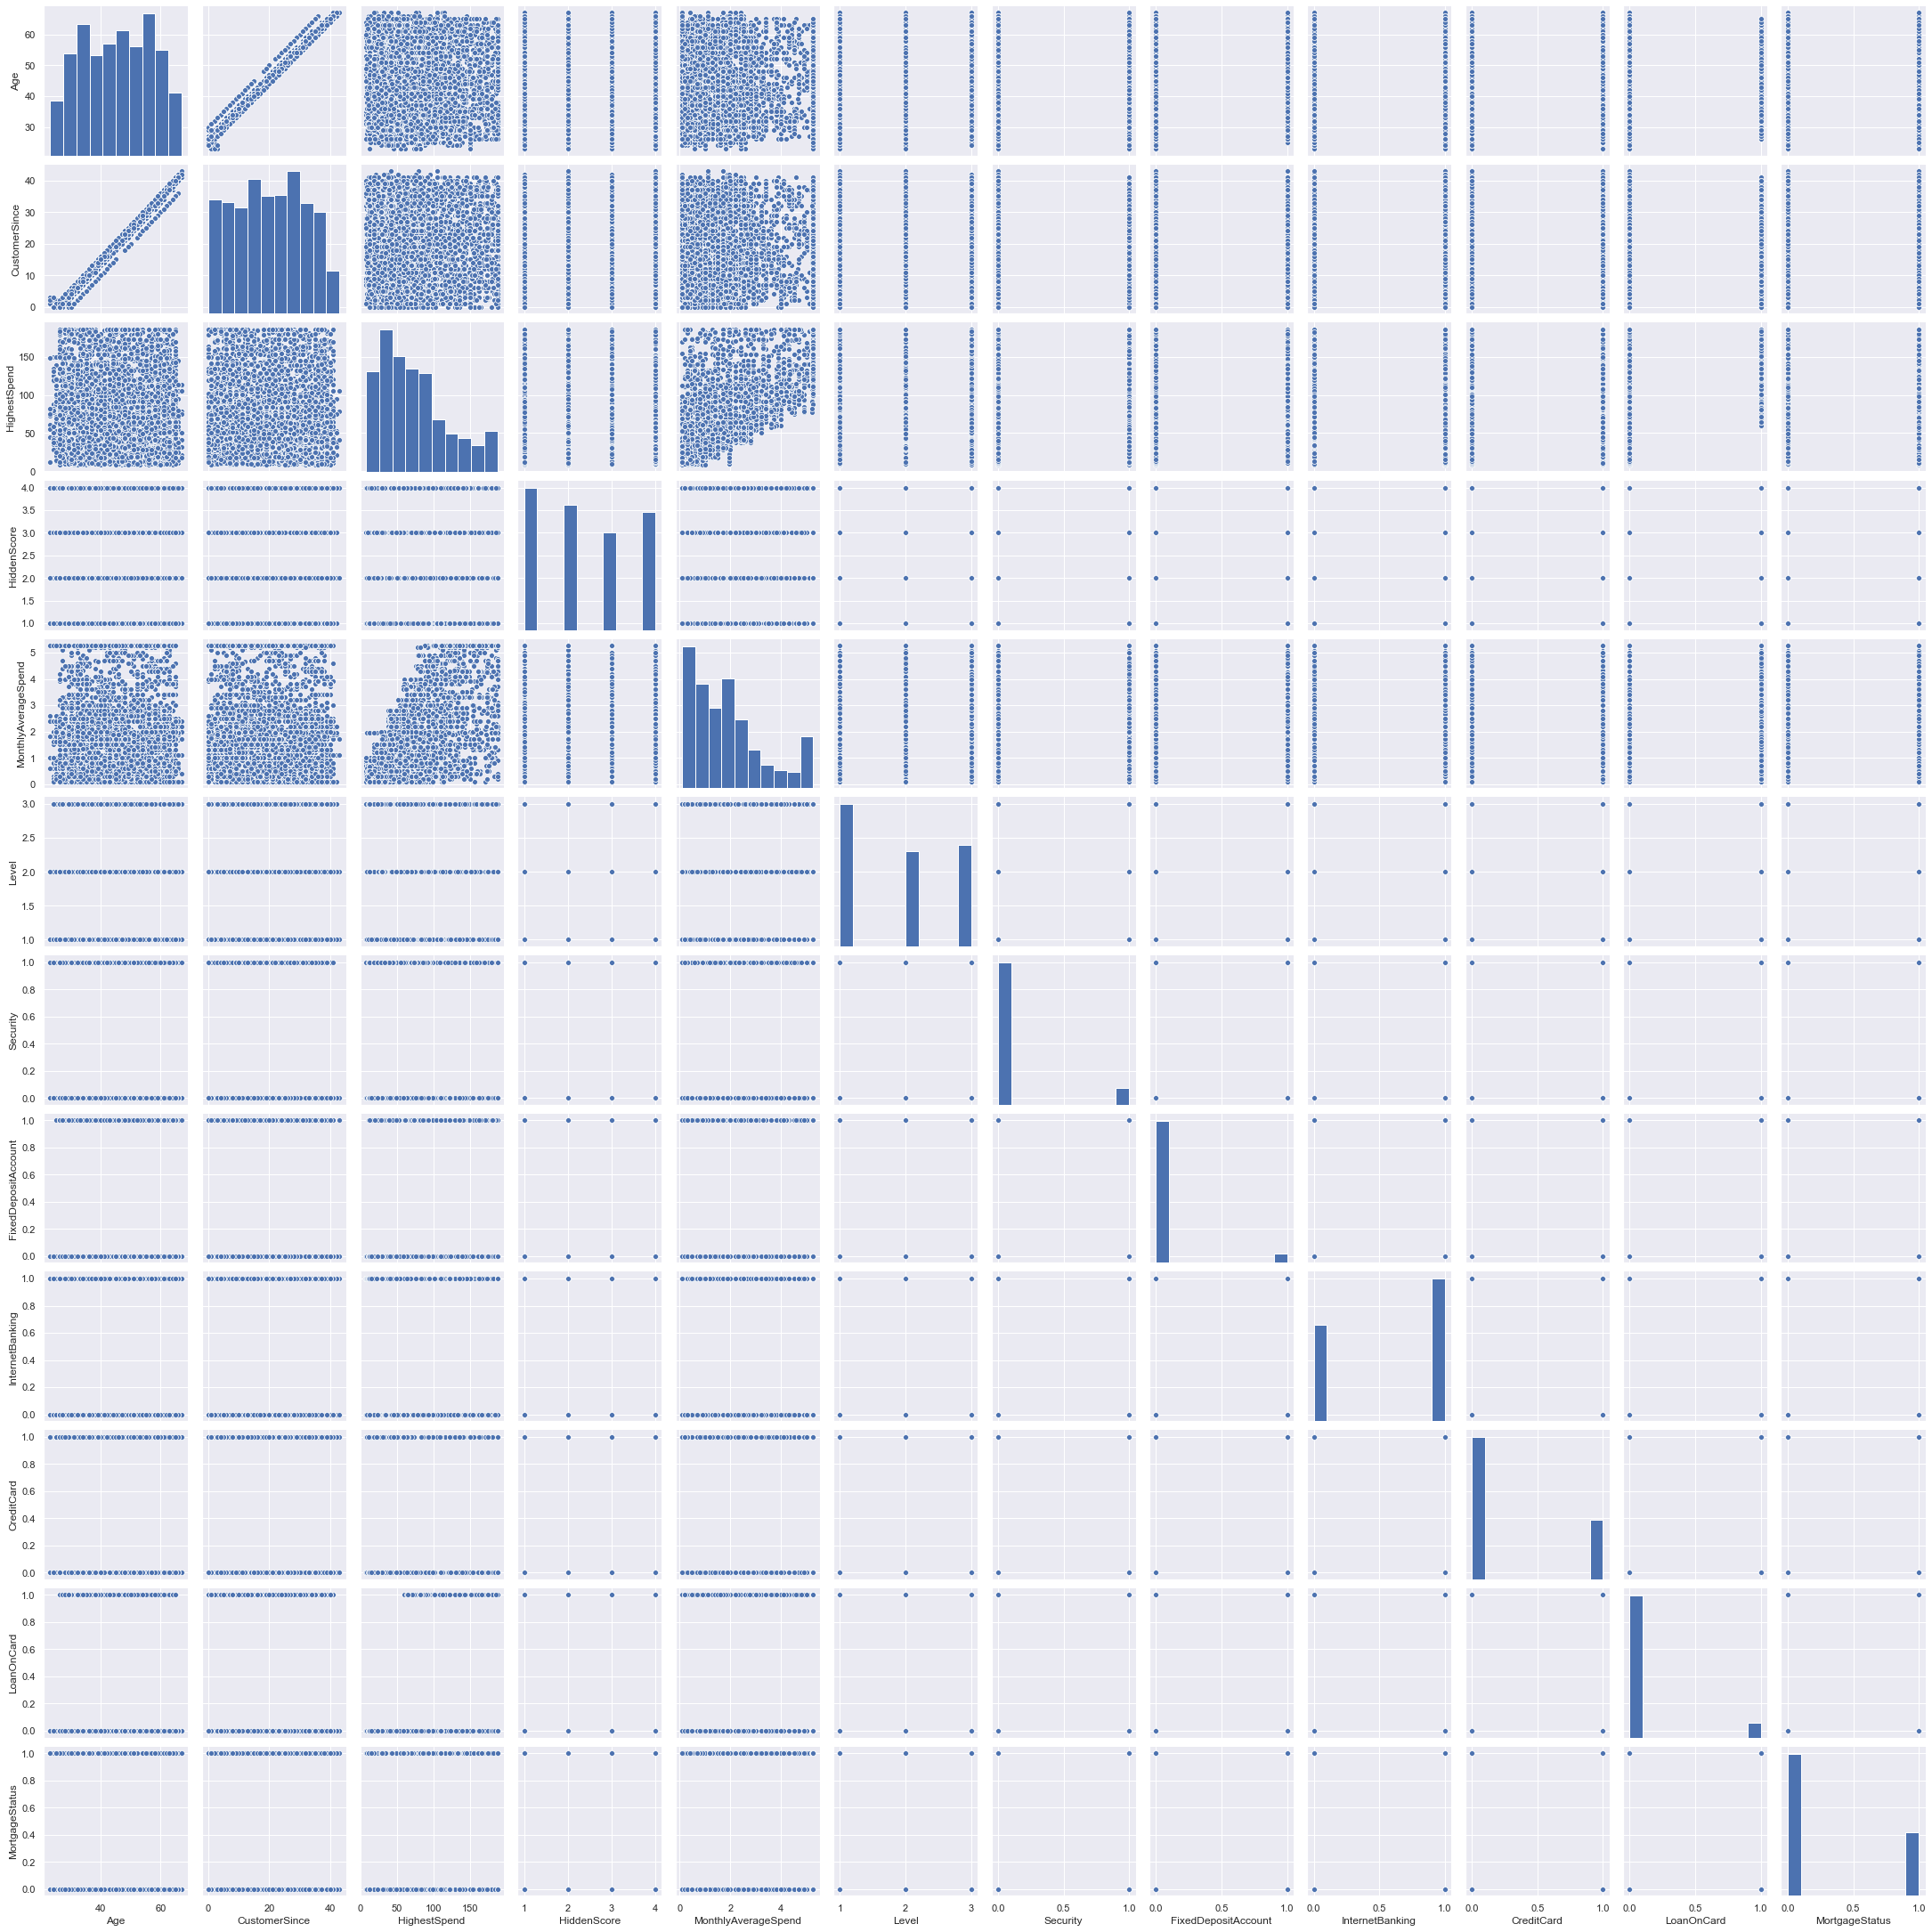

In [24]:
sns.pairplot(data=df1);

* There is a very strong (almost perfect) positive relationship between Age and CustomerSince.
* Customers with higher Monthly Average Spend has larger amount of Highest Spend.
* Customers with loan amount have higher Highest Spend.

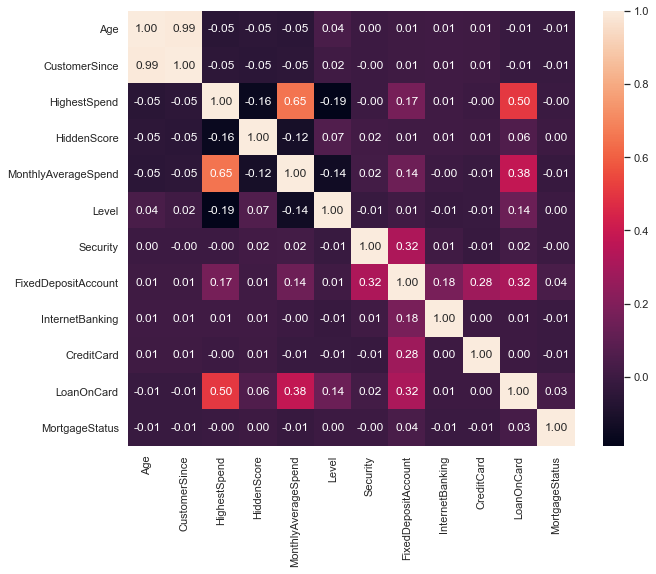

In [25]:
f,ax=plt.subplots(figsize=(10,8));
sns.heatmap(df1.corr(),annot=True,fmt='.2f');
plt.show();

* The correlation between Age and CustomerSince is 0.99. This may cause issues of multi-collinearity while modelling. Depending on the modelling results we will decide on dropping any of them.

* HighestSpend and AvgMonthly Spend has a moderate strong correlation of 0.65. However, we will impute the 0 values considering them as missing.

In [26]:
# Calculating percentage of observations with erroneous data

print("Erroneous percentage:",100*((df1['LoanOnCard'] == 1) & (df1['CreditCard'] == 0)).sum()/len(df1.index))

Erroneous percentage: 6.767068273092369


In [27]:
# Drop the erroneous rows

df2=df1.copy()
index_names = df2[ (df2['LoanOnCard'] ==1) & (df2['CreditCard'] ==0)].index
df2.drop(index_names, inplace = True)
df2.shape

# Calculating percenatge of data lost (due to missing value and error) compared to our original data

((5000-4643)/5000)*100

(4643, 12)

7.140000000000001

* We have lost 7% data but still the data is enough to carry out analysis.
* We will re-calculate the distribution of target variable. However, this will cause further imbalance in the target variable.

In [28]:
df2.LoanOnCard.value_counts(normalize=True)

0.0    0.969201
1.0    0.030799
Name: LoanOnCard, dtype: float64

* As expected, the removal of those erroneous rows have made the target variable more imbalanced, with 97% 0s (i.e. no loan) and 3% 1s (i.e. they have a loan on card).

In [29]:
df2.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Age,4643.0,45.387896,11.451078,23.0,35.0,45.0,55.0,67.0000
CustomerSince,4643.0,20.186948,11.401506,0.0,10.0,20.0,30.0,43.0000
HighestSpend,4643.0,68.593797,42.205591,8.0,38.0,61.0,89.0,186.5000
HiddenScore,4643.0,2.382511,1.148839,1.0,1.0,2.0,3.0,4.0000
MonthlyAverageSpend,4643.0,1.758157,1.350478,0.1,0.7,1.5,2.4,5.2625
Level,4643.0,1.853974,0.840461,1.0,1.0,2.0,3.0,3.0000
Security,4643.0,0.102735,0.303646,0.0,0.0,0.0,0.0,1.0000
FixedDepositAccount,4643.0,0.054921,0.227851,0.0,0.0,0.0,0.0,1.0000
InternetBanking,4643.0,0.595520,0.490844,0.0,0.0,1.0,1.0,1.0000
CreditCard,4643.0,0.315744,0.464862,0.0,0.0,0.0,1.0,1.0000


We will now move ahead to fit the model. However, before that will perform the data pre-processing.

<a id='Pre-processing'></a>

# Data Pre-Processing

#### Segregate predictors vs target attributes

In [30]:
# Segregate predictors vs target attributes

X = df2.drop('LoanOnCard',axis=1)
Y = df2['LoanOnCard']

Y.head()

10    0.0
11    0.0
12    0.0
13    0.0
14    0.0
Name: LoanOnCard, dtype: float64

#### Check for target balancing

In [31]:
print("Original LoanOnCard - 0 values    : {0} ({1:0.2f}%)".format(len(df2.loc[df2['LoanOnCard'] == 0]), (len(df2.loc[df2['LoanOnCard'] == 0])/len(df2.index)) * 100))
print("Original LoanOnCard - 1 values    : {0} ({1:0.2f}%)".format(len(df2.loc[df2['LoanOnCard'] == 1]), (len(df2.loc[df2['LoanOnCard'] == 1])/len(df2.index)) * 100))


Original LoanOnCard - 0 values    : 4500 (96.92%)
Original LoanOnCard - 1 values    : 143 (3.08%)


* As mentioned before, the target is imbalanced with only 3% true values. We will need to fix this. However, we will first perform Logistic on original data so that we can compare later when we have fixed the imbalance issue.

#### Perform train-test split

In [32]:
# Perform 70:30 train:test split with stratify sampling on target variable to maintain the distribution of dependent variable

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=1,stratify=df2['LoanOnCard'])

print("Train LoanOnCard - 0 values    : {0} ({1:0.2f}%)".format(len(y_train.loc[y_train[:] == 0]), (len(y_train.loc[y_train[:] == 0])/len(y_train.index)) * 100))
print("Train LoanOnCard - 1 values    : {0} ({1:0.2f}%)".format(len(y_train.loc[y_train[:] == 1]), (len(y_train.loc[y_train[:] == 1])/len(y_train.index)) * 100))

print()
print()

print("Train LoanOnCard - 0 values    : {0} ({1:0.2f}%)".format(len(y_test.loc[y_test[:] == 0]), (len(y_test.loc[y_test[:] == 0])/len(y_test.index)) * 100))
print("Train LoanOnCard - 1 values    : {0} ({1:0.2f}%)".format(len(y_test.loc[y_test[:] == 1]), (len(y_test.loc[y_test[:] == 1])/len(y_test.index)) * 100))



Train LoanOnCard - 0 values    : 3150 (96.92%)
Train LoanOnCard - 1 values    : 100 (3.08%)


Train LoanOnCard - 0 values    : 1350 (96.91%)
Train LoanOnCard - 1 values    : 43 (3.09%)


* In both the train and test data sets the distribution of target variables are similar and also align with the original data set, i.e. 97% 0s and 3% 1s.

<a id='Model'></a>

# Model training, testing and tuning

LogisticRegression(solver='liblinear')

        Age  CustomerSince  HighestSpend  HiddenScore  MonthlyAverageSpend  \
0 -0.589229       0.592794      0.048069     0.704914             0.316345   

      Level  Security  FixedDepositAccount  InternetBanking  CreditCard  \
0  1.518307 -1.302066             3.299841        -2.154984    2.753452   

   MortgageStatus  intercept  
0        0.247128  -1.043061  

Accuracy of Training Data: 0.9870769230769231
Accuracy of Test Data: 0.9877961234745154

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99      1350
         1.0       0.88      0.70      0.78        43

    accuracy                           0.99      1393
   macro avg       0.94      0.85      0.89      1393
weighted avg       0.99      0.99      0.99      1393



(<Figure size 504x360 with 0 Axes>,)

(<matplotlib.axes._subplots.AxesSubplot at 0x20c4ec497f0>,)

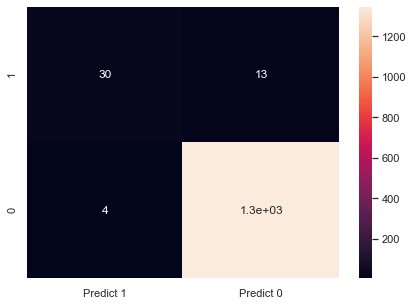

(None,)


ROC AUC Score:  0.8473557278208441


In [33]:
    # Fit the model on train
    model = LogisticRegression(solver="liblinear")
    model.fit(x_train, y_train)
    
    #predict on test
    y_predict = model.predict(x_test)
    y_predictprob = model.predict_proba(x_test)
    
    
    # co-efficients
    coef_df = pd.DataFrame(model.coef_,columns=list(x_train.columns))
    coef_df['intercept'] = model.intercept_
    print(coef_df)
    print()
    
    #Accuracy
    model_score = model.score(x_train, y_train)
    print(f"Accuracy of Training Data: {model_score}")
    model_score = model.score(x_test, y_test)
    print(f"Accuracy of Test Data: {model_score}")
    print()
    
    # Confusion Matrix
    print(metrics.classification_report(y_test,y_predict))
    cm=metrics.confusion_matrix(y_test, y_predict, labels=[1, 0])

    df_cm = pd.DataFrame(cm, index = [i for i in ["1","0"]],
                      columns = [i for i in ["Predict 1","Predict 0"]])
    plt.figure(figsize = (7,5)),
    sns.heatmap(df_cm, annot=True),
    plt.show(),
    
    print()
    print("ROC AUC Score: ",metrics.roc_auc_score(y_test,y_predict))


* The training and test accuracies are both around 98% which is good. However, since this is an imbalanced target data we will look into other metrics. For imbalanced target high accuracy can be easily achieved by labelling everyone into one class.

* Precision ( = True Positive / (True Positive + False Positive) ) is the ratio of correctly predicted positive observations to the total predicted positive observations. Here precison for target 1 is 0.88 i.e. for all the customers who have been predicted have been predicted have a loan 88% have a loan.

* Recall (= True Positive / (True Positive + False Negative) ) is the atio of correctly predicted positive observations to all observations in actual class yes. Here Recall for target 1 is 0.70 i.e. out of all the customers who have a loan 70% have been predicted correctly. On the otherhand Recall for Class 0 is 1.00, which means the model is able to identify almost all the non-loaners.


#### Tuning

* The LogisticRegression takes L2 regularisation into account. So we will apply L1 as penalty and negate the Cost Function to check results.

In [34]:
model_l1 = LogisticRegression(solver="liblinear",penalty='l1',C=1e42)
model_l1.fit(x_train, y_train)
    

#Accuracy
model_score_l1 = model_l1.score(x_train, y_train)
print(f"Accuracy of Training Data: {model_score_l1}")
model_score_l1 = model_l1.score(x_test, y_test)
print(f"Accuracy of Test Data: {model_score_l1}")




LogisticRegression(C=1e+42, penalty='l1', solver='liblinear')

Accuracy of Training Data: 0.9867692307692307
Accuracy of Test Data: 0.9856424982053122


* The accuracy remains almost same. We proceed with other metrices.

        Age  CustomerSince  HighestSpend  HiddenScore  MonthlyAverageSpend  \
0 -0.075617        0.08711      0.056407     0.810148             0.337017   

      Level  Security  FixedDepositAccount  InternetBanking  CreditCard  \
0  1.549735 -2.634287             6.030688        -4.522365    8.158943   

   MortgageStatus  intercept  
0        0.228502 -20.718381  

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      1350
         1.0       0.81      0.70      0.75        43

    accuracy                           0.99      1393
   macro avg       0.90      0.85      0.87      1393
weighted avg       0.98      0.99      0.99      1393



(<Figure size 504x360 with 0 Axes>,)

(<matplotlib.axes._subplots.AxesSubplot at 0x20c4d4b86d0>,)

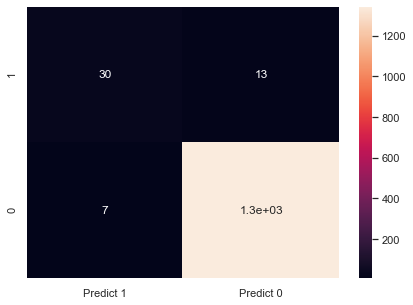

(None,)


ROC AUC Score:  0.8462446167097329


In [36]:
#predict on test
y_predict_l1 = model_l1.predict(x_test)
y_predictprob_l1 = model_l1.predict_proba(x_test)
    
    
# co-efficients
coef_df_l1 = pd.DataFrame(model_l1.coef_,columns=list(x_train.columns))
coef_df_l1['intercept'] = model_l1.intercept_
print(coef_df_l1)
print()

# Confusion Matrix
print(metrics.classification_report(y_test,y_predict_l1))
cm=metrics.confusion_matrix(y_test, y_predict_l1, labels=[1, 0])

df_cm = pd.DataFrame(cm, index = [i for i in ["1","0"]],
                      columns = [i for i in ["Predict 1","Predict 0"]])
plt.figure(figsize = (7,5)),
sns.heatmap(df_cm, annot=True),
plt.show(),
    
print()
print("ROC AUC Score: ",metrics.roc_auc_score(y_test,y_predict_l1))


* The ROC value remains same, however, the precision fall.

#### Target balancing techniques:
1. Up sampling
2. Down sampling



* Up-sampling increases the minority class and hence tends to overfit the data while down sampling decreases the majority class and hence the data suffers from loss of information. We will apply both and will decide on which one to use depednding on the metrices.

In [37]:
# Up-sampling



# Separate majority and minority classes
df_majority = df2[df2["LoanOnCard"]==0]
df_minority = df2[df2["LoanOnCard"]==1]
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=4500,    # to match majority class
                                 random_state=20) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_upsampled.LoanOnCard.value_counts()

1.0    4500
0.0    4500
Name: LoanOnCard, dtype: int64

In [38]:
# Separate input features (X) and target variable (y)
y1 = df_upsampled.LoanOnCard
X1 = df_upsampled.drop('LoanOnCard', axis=1)
 
# Train model
clf_1 = LogisticRegression().fit(X1, y1)
 
# Predict on training set
pred_y_1 = clf_1.predict(X1)
 
# Is our model still predicting just one class?
print( np.unique( pred_y_1 ) )
# [0 1]
 
# Accuracy
print("The accuracy is:", accuracy_score(y1, pred_y_1) )

[0. 1.]
The accuracy is: 0.974


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [39]:
 # co-efficients
coef_df = pd.DataFrame(clf_1.coef_,columns=list(X1.columns))
coef_df['intercept'] = clf_1.intercept_
print(coef_df)

        Age  CustomerSince  HighestSpend  HiddenScore  MonthlyAverageSpend  \
0 -0.660978       0.652523      0.048238     0.891751             0.760366   

      Level  Security  FixedDepositAccount  InternetBanking  CreditCard  \
0  1.310808  -0.61977             4.638403        -3.130964    6.391364   

   MortgageStatus  intercept  
0       -0.335345  -0.393199  


              precision    recall  f1-score   support

         0.0       0.99      0.96      0.97      4500
         1.0       0.96      0.99      0.97      4500

    accuracy                           0.97      9000
   macro avg       0.97      0.97      0.97      9000
weighted avg       0.97      0.97      0.97      9000



(<Figure size 504x360 with 0 Axes>,)

(<matplotlib.axes._subplots.AxesSubplot at 0x20c4d317f40>,)

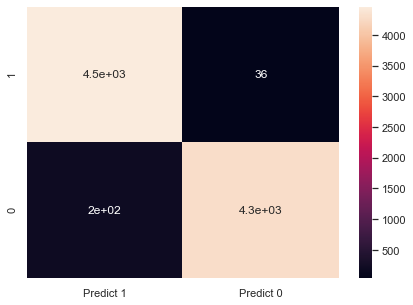

(None,)


ROC AUC Score:  0.9739999999999999


In [40]:
 # Confusion Matrix
print(metrics.classification_report(y1,pred_y_1)) 
cm=metrics.confusion_matrix(y1, pred_y_1, labels=[1, 0])

df_cm = pd.DataFrame(cm, index = [i for i in ["1","0"]],
                      columns = [i for i in ["Predict 1","Predict 0"]])
plt.figure(figsize = (7,5)),
sns.heatmap(df_cm, annot=True),
plt.show(),
    
print()
print("ROC AUC Score: ",metrics.roc_auc_score(y1,pred_y_1))

In [34]:
logit_model=sm.Logit(y1,X1)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.079180
         Iterations 11
                           Results: Logit
Model:                Logit             Pseudo R-squared:  0.886    
Dependent Variable:   LoanOnCard        AIC:               1447.2336
Date:                 2021-02-12 12:17  BIC:               1525.3884
No. Observations:     9000              Log-Likelihood:    -712.62  
Df Model:             10                LL-Null:           -6238.3  
Df Residuals:         8989              LLR p-value:       0.0000   
Converged:            1.0000            Scale:             1.0000   
No. Iterations:       11.0000                                       
--------------------------------------------------------------------
                     Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
--------------------------------------------------------------------
Age                 -0.6924   0.0309 -22.3944 0.0000 -0.7530 -0.6318
CustomerSince        0.6819

* From p-values we find all features are significant.

In [41]:
# Down sampling

# Separate majority and minority classes
df_majority = df2[df2["LoanOnCard"]==0]
df_minority = df2[df2["LoanOnCard"]==1]
 
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=143,     # to match minority class
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
df_downsampled.LoanOnCard.value_counts()


1.0    143
0.0    143
Name: LoanOnCard, dtype: int64

In [42]:
# Separate input features (X) and target variable (y)
y2 = df_downsampled.LoanOnCard
X2 = df_downsampled.drop('LoanOnCard', axis=1)

# Train model
clf_2 = LogisticRegression().fit(X2, y2)
 
# Predict on training set
pred_y_2 = clf_2.predict(X2)
 
# Is our model still predicting just one class?
print( np.unique( pred_y_2 ) )
 
# accuracy
print( "The accuracy is:",accuracy_score(y2, pred_y_2) )

[0. 1.]
The accuracy is: 0.965034965034965


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [43]:
 # co-efficients
coef_df = pd.DataFrame(clf_2.coef_,columns=list(X2.columns))
coef_df['intercept'] = clf_2.intercept_
print(coef_df)

        Age  CustomerSince  HighestSpend  HiddenScore  MonthlyAverageSpend  \
0 -0.503318       0.511975      0.045631     0.536813             0.529944   

      Level  Security  FixedDepositAccount  InternetBanking  CreditCard  \
0  1.167242 -0.176501             2.184721        -0.651363    3.192664   

   MortgageStatus  intercept  
0       -0.074413  -0.165904  


              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97       143
         1.0       0.97      0.97      0.97       143

    accuracy                           0.97       286
   macro avg       0.97      0.97      0.97       286
weighted avg       0.97      0.97      0.97       286



(<Figure size 504x360 with 0 Axes>,)

(<matplotlib.axes._subplots.AxesSubplot at 0x20c4ea0d280>,)

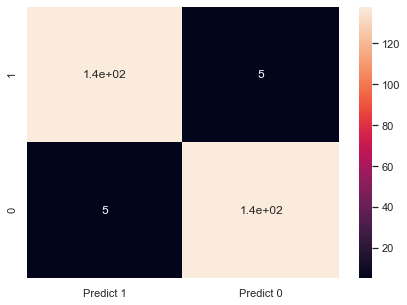

(None,)


ROC AUC Score:  0.965034965034965


In [44]:
 # Confusion Matrix
print(metrics.classification_report(y2,pred_y_2)) 
cm=metrics.confusion_matrix(y2, pred_y_2, labels=[1, 0])

df_cm = pd.DataFrame(cm, index = [i for i in ["1","0"]],
                      columns = [i for i in ["Predict 1","Predict 0"]])
plt.figure(figsize = (7,5)),
sns.heatmap(df_cm, annot=True),
plt.show(),
    
print()
print("ROC AUC Score: ",metrics.roc_auc_score(y2,pred_y_2))

In [45]:

logit_model=sm.Logit(y2,X2)
result=logit_model.fit()
print(result.summary2())

         Current function value: 0.070206
         Iterations: 35
                                 Results: Logit
Model:                   Logit                 Pseudo R-squared:      0.899     
Dependent Variable:      LoanOnCard            AIC:                   62.1581   
Date:                    2021-02-12 21:02      BIC:                   102.3740  
No. Observations:        286                   Log-Likelihood:        -20.079   
Df Model:                10                    LL-Null:               -198.24   
Df Residuals:            275                   LLR p-value:           1.8134e-70
Converged:               0.0000                Scale:                 1.0000    
No. Iterations:          35.0000                                                
--------------------------------------------------------------------------------
                     Coef.     Std.Err.     z    P>|z|     [0.025       0.975]  
----------------------------------------------------------------------------

C:\Users\User\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


* In terms of ROC score and Accuracy both Up and Down Sampling are almost same.
* In terms of Precision Up-sampling has 96% precison while Down sampling has 97% precision. Here precision is the most important metric and we would prefer higher precision. We would want that all the predicted customers for loan actually takes loan. If we predict a customer will take loan but actually he doesn't then that's a loss for bank. Reversely, if we fail to identify all customers who will take a loan that may not harm the bank much.
* Hence we move ahead with down-sampling since it has 1% more precision.
* Also, from variable importannce we see features "FixedDepositAccount", "InternetBanking", "HiddenScore","MonthlyAverageSpend", "Security" and "MortgageStatus" have p-values less than 0.05. Hence we may try to drop them and see if our model is better.

[0. 1.]
0.9475524475524476
              precision    recall  f1-score   support

         0.0       0.96      0.94      0.95       143
         1.0       0.94      0.96      0.95       143

    accuracy                           0.95       286
   macro avg       0.95      0.95      0.95       286
weighted avg       0.95      0.95      0.95       286



C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


(<Figure size 504x360 with 0 Axes>,)

(<matplotlib.axes._subplots.AxesSubplot at 0x20c4e7c2b80>,)

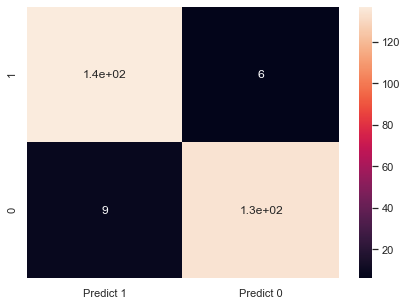

(None,)


ROC AUC Score:  0.9475524475524476


In [46]:
#Iteration 1 on down sampling
# Drop Fixed Deposit and Internet Banking since they have the highest p-vale

X_it1 = df_downsampled.drop(["LoanOnCard","FixedDepositAccount","InternetBanking"],axis=1)
y_it1 = df_downsampled.LoanOnCard

# Train model
clf_it1 = LogisticRegression().fit(X_it1, y_it1)
 
# Predict on training set
pred_y_it1 = clf_it1.predict(X_it1)
 
# Is our model still predicting just one class?
print( np.unique( pred_y_it1 ) )
 
# accuracy?
print( accuracy_score(y_it1, pred_y_it1) )



 # Confusion Matrix
print(metrics.classification_report(y_it1,pred_y_it1)) 
cm=metrics.confusion_matrix(y_it1, pred_y_it1, labels=[1, 0])

df_cm = pd.DataFrame(cm, index = [i for i in ["1","0"]],
                      columns = [i for i in ["Predict 1","Predict 0"]])
plt.figure(figsize = (7,5)),
sns.heatmap(df_cm, annot=True),
plt.show(),
    
print()
print("ROC AUC Score: ",metrics.roc_auc_score(y_it1,pred_y_it1))

[0. 1.]
0.9685314685314685
              precision    recall  f1-score   support

         0.0       0.98      0.96      0.97       143
         1.0       0.96      0.98      0.97       143

    accuracy                           0.97       286
   macro avg       0.97      0.97      0.97       286
weighted avg       0.97      0.97      0.97       286



C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


(<Figure size 504x360 with 0 Axes>,)

(<matplotlib.axes._subplots.AxesSubplot at 0x20c4be9e3d0>,)

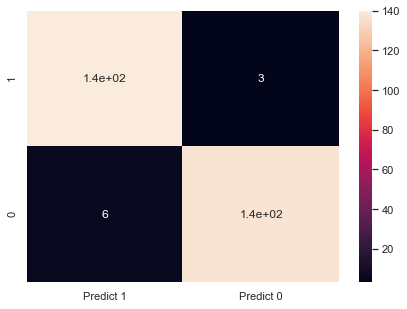

(None,)


ROC AUC Score:  0.9685314685314687


In [47]:
#Iteration 2 on down sampling
# Drop

X_it2 = df_downsampled.drop(["LoanOnCard","HiddenScore"],axis=1)
y_it2 = df_downsampled.LoanOnCard

# Train model
clf_it2 = LogisticRegression().fit(X_it2, y_it2)
 
# Predict on training set
pred_y_it2 = clf_it2.predict(X_it2)
 
# Is our model still predicting just one class?
print( np.unique( pred_y_it2 ) )
 
# accuracy
print( accuracy_score(y_it2, pred_y_it2) )



 # Confusion Matrix
print(metrics.classification_report(y_it2,pred_y_it2)) 
cm=metrics.confusion_matrix(y_it2, pred_y_it2, labels=[1, 0])

df_cm = pd.DataFrame(cm, index = [i for i in ["1","0"]],
                      columns = [i for i in ["Predict 1","Predict 0"]])
plt.figure(figsize = (7,5)),
sns.heatmap(df_cm, annot=True),
plt.show(),
    
print()
print("ROC AUC Score: ",metrics.roc_auc_score(y_it2,pred_y_it2))

* By removing the less important variables (larger p-values) we do not see any improvement. This could be due to a smaller data-set. Hence we move ahead with Down-sampling with all features retained.

#### Fitting Naive Bayes

We can fit 3 types of Naive Bayes :

1. Gaussian - when predictors are continuous
2. Multinomial - when features are count
3. Bernoulli - when features are binary


Here, the predictors are of mixed nature.
* Hence, we will seggregate the train and test data into continuous and categorical features.
* We will fit a Gaussian NB on continuous and Multinomial on categorical.
* We will use the probabilities of target prediction and build a new Naive Bayes using original y-values and the probabilities. This time we can use a Gaussian NB as now both our predictors are continuous. Since NB assumes indpendence of predictors we can implement this method.

In [48]:
x_train.head()

,Age,CustomerSince,HighestSpend,HiddenScore,MonthlyAverageSpend,Level,Security,FixedDepositAccount,InternetBanking,CreditCard,MortgageStatus
2933,47,22,42.0,3,2.7,2,0,0,1,0,0.0
1202,35,11,24.0,4,0.4,2,0,0,0,0,0.0
4204,40,16,61.0,3,2.1,3,0,0,0,0,0.0
1861,62,38,161.0,1,2.9,1,1,1,1,1,0.0
3032,47,22,19.0,1,0.4,3,0,0,1,0,0.0


In [49]:
# Building different datasets with categorical and continuous features

x_train_c = x_train[["HiddenScore","Level","Security","FixedDepositAccount","InternetBanking","CreditCard","MortgageStatus"]]
x_test_c = x_test[["HiddenScore","Level","Security","FixedDepositAccount","InternetBanking","CreditCard","MortgageStatus"]]

x_train_g = x_train[["Age","CustomerSince","HighestSpend","MonthlyAverageSpend"]]
x_test_g = x_test[["Age","CustomerSince","HighestSpend","MonthlyAverageSpend"]]


In [50]:
# Fitting Gaussian model on continuous features and Multinomial Model on Categorical Features

nbg = GaussianNB()
nbc = MultinomialNB()

g=nbg.fit(x_train_g, y_train)
c=nbc.fit(x_train_c, y_train)

#predict probabilities on train and test sets for only target = 1

y_predictprob_trg = g.predict_proba(x_train_g)[:,1] # training gaussian data
y_predictprob_tsg = g.predict_proba(x_test_g)[:,1] # test gaussian data

y_predictprob_trc = c.predict_proba(x_train_c)[:,1] # training categorical data
y_predictprob_tsc = c.predict_proba(x_test_c)[:,1] # test categorical data

In [51]:
# Creating new training and test datasets with the probabilities

# Create series from the probablities which are actually arrays

ser_trg = pd.Series(y_predictprob_trg)
ser_tsg = pd.Series(y_predictprob_tsg)
ser_trc = pd.Series(y_predictprob_trc)
ser_tsc = pd.Series(y_predictprob_tsc)

# Create dictionaries using the series

train = {"Prob_gaussian": ser_trg, 
        "Prob_cat": ser_trc}

test = {"Prob_gaussian": ser_tsg, 
        "Prob_cat": ser_tsc}

# Create dataframes for train and test

x_tr_new = pd.concat(train, axis = 1)
x_ts_new = pd.concat(test, axis = 1)

x_tr_new.shape
x_ts_new.shape

x_tr_new.head()
x_ts_new.head()

(3250, 2)

(1393, 2)

,Prob_gaussian,Prob_cat
0,0.000124,0.009175
1,0.000004,0.011528
2,0.000479,0.012443
3,0.398949,0.264891
4,0.000002,0.011984


,Prob_gaussian,Prob_cat
0,9.351588e-07,0.222446
1,7.531273e-06,0.015046
2,4.410362e-02,0.037210
3,2.628544e-03,0.014160
4,1.038213e-06,0.042193


In [52]:
# Fitting Gaussian NB now as the predictors are continous

nb1=nbg.fit(x_tr_new, y_train)

# Predicting y-values on test data

y_pred1 = nb1.predict(x_ts_new)

# Accuracies

print(f"Accuracy of training data = {nb1.score(x_tr_new, y_train)}")
print(f"Accuracy of test data = {nb1.score(x_ts_new, y_test)}")

Accuracy of training data = 0.9261538461538461
Accuracy of test data = 0.9318018664752333


              precision    recall  f1-score   support

         0.0       0.99      0.94      0.96      1350
         1.0       0.29      0.81      0.42        43

    accuracy                           0.93      1393
   macro avg       0.64      0.87      0.69      1393
weighted avg       0.97      0.93      0.95      1393



(<Figure size 504x360 with 0 Axes>,)

(<matplotlib.axes._subplots.AxesSubplot at 0x20c4d481e80>,)

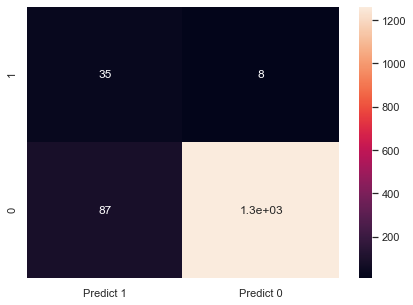

(None,)

ROC AUC Score:  0.8747545219638244


In [53]:
 # Confusion Matrix
print(metrics.classification_report(y_test,y_pred1)) 
cm=metrics.confusion_matrix(y_test, y_pred1, labels=[1, 0])

df_cm = pd.DataFrame(cm, index = [i for i in ["1","0"]],
                      columns = [i for i in ["Predict 1","Predict 0"]])
plt.figure(figsize = (7,5)),
sns.heatmap(df_cm, annot=True),
plt.show(),
    
print("ROC AUC Score: ",metrics.roc_auc_score(y_test,y_pred1))

* Though the accuracy on test data is good, the precision for target 1 is 0.29 i.e. very low. As explained previously bank would prefer to have a high precision here. Hence we cannot move ahead with this model. NB does not have any hyper parameter. However, we can use 'priors' and 'var_smoothing' for tuning.

* We try once with resampling techniques, since the target class is imbalanced to check if we get better results.

In [54]:
# Repeating same procedure as done to original data with Up-sampling data

# Seggregating categorical and gaussian features

x1_c = X1[["HiddenScore","Level","Security","FixedDepositAccount","InternetBanking","CreditCard","MortgageStatus"]]
x1_g = X1[["Age","CustomerSince","HighestSpend","MonthlyAverageSpend"]]

# Building gaussian and categorical NBs

g_up=nbg.fit(x1_g, y1)
c_up=nbc.fit(x1_c, y1)

# Probablities of target 1 for both models

y_predictprob_g = g_up.predict_proba(x1_g)[:,1]
y_predictprob_c = c_up.predict_proba(x1_c)[:,1]

# Creating series with the probablities

ser_up_g = pd.Series(y_predictprob_g)
ser_up_c = pd.Series(y_predictprob_c)

# Create dictionaries using the series

train_up = {"Prob_gaussian": ser_up_g, 
        "Prob_cat": ser_up_c}

#Creating data for model building

x1_up = pd.concat(train_up, axis = 1)

In [55]:
# Train model
nb2=nbg.fit(x1_up, y1)
 
# Predict on training set
pred_y_1_up = nb2.predict(x1_up)
 
# Is our model still predicting just one class?
print( np.unique( pred_y_1_up ) )
# [0 1]
 
# accuracy
print( accuracy_score(y1, pred_y_1_up) )

[0. 1.]
0.9075555555555556


              precision    recall  f1-score   support

         0.0       0.93      0.89      0.91      4500
         1.0       0.89      0.93      0.91      4500

    accuracy                           0.91      9000
   macro avg       0.91      0.91      0.91      9000
weighted avg       0.91      0.91      0.91      9000



(<Figure size 504x360 with 0 Axes>,)

(<matplotlib.axes._subplots.AxesSubplot at 0x20c4edabb80>,)

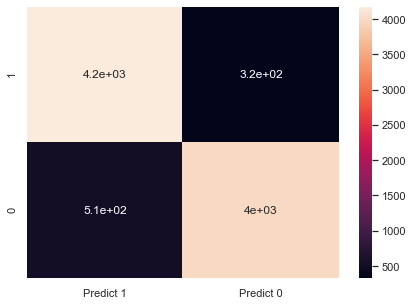

(None,)


ROC AUC Score:  0.9075555555555556


In [56]:
 # Confusion Matrix
print(metrics.classification_report(y1,pred_y_1_up)) 
cm=metrics.confusion_matrix(y1, pred_y_1_up, labels=[1, 0])

df_cm = pd.DataFrame(cm, index = [i for i in ["1","0"]],
                      columns = [i for i in ["Predict 1","Predict 0"]])
plt.figure(figsize = (7,5)),
sns.heatmap(df_cm, annot=True),
plt.show(),
    
print()
print("ROC AUC Score: ",metrics.roc_auc_score(y1,pred_y_1_up))

* We see a considerable increase in the precision. Precision is now 0.89, i.e. if a customer is predicted as a loaner, 89% times he is a loaner.

* With this information we move to down-sampling.

In [57]:
# Repeating same procedure as done to original data with Down-sampling data

# Seggregating categorical and gaussian features

x2_c = X2[["HiddenScore","Level","Security","FixedDepositAccount","InternetBanking","CreditCard","MortgageStatus"]]
x2_g = X2[["Age","CustomerSince","HighestSpend","MonthlyAverageSpend"]]

# Building gaussian and categorical NBs

g_dn=nbg.fit(x2_g, y2)
c_dn=nbc.fit(x2_c, y2)

# Probablities of target 1 for both models

y_predictprob_g_dn = g_dn.predict_proba(x2_g)[:,1]
y_predictprob_c_dn = c_dn.predict_proba(x2_c)[:,1]

# Creating series with the probablities

ser_dn_g = pd.Series(y_predictprob_g_dn)
ser_dn_c = pd.Series(y_predictprob_c_dn)

# Create dictionaries using the series

train_dn = {"Prob_gaussian": ser_dn_g, 
        "Prob_cat": ser_dn_c}

#Creating data for model building

x2_dn = pd.concat(train_dn, axis = 1)

In [58]:
# Train model
nb3=nbg.fit(x2_dn, y2)
 
# Predict on training set
pred_y_2_dn = nb3.predict(x2_dn)
 
# Is our model still predicting just one class?
print( np.unique( pred_y_2_dn ) )
# [0 1]
 
# accuracy
print( accuracy_score(y2, pred_y_2_dn) )

[0. 1.]
0.916083916083916


              precision    recall  f1-score   support

         0.0       0.93      0.90      0.91       143
         1.0       0.90      0.93      0.92       143

    accuracy                           0.92       286
   macro avg       0.92      0.92      0.92       286
weighted avg       0.92      0.92      0.92       286



(<Figure size 504x360 with 0 Axes>,)

(<matplotlib.axes._subplots.AxesSubplot at 0x20c4f755d30>,)

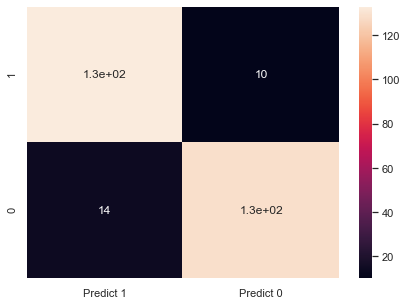

(None,)


ROC AUC Score:  0.916083916083916


In [59]:
 # Confusion Matrix
print(metrics.classification_report(y2,pred_y_2_dn)) 
cm=metrics.confusion_matrix(y2, pred_y_2_dn, labels=[1, 0])

df_cm = pd.DataFrame(cm, index = [i for i in ["1","0"]],
                      columns = [i for i in ["Predict 1","Predict 0"]])
plt.figure(figsize = (7,5)),
sns.heatmap(df_cm, annot=True),
plt.show(),
    
print()
print("ROC AUC Score: ",metrics.roc_auc_score(y2,pred_y_2_dn))

* The precison is 0.9 i.e. it has gone up by 1% compared to up-sampling.
* We will collate the results of all the iterations (both logistic and NB) and decide on our final model.

| Model | Accuracy | ROC | Precision | Recall |
| --- | --- | --- | --- | --- |
| Logistic - Original Data | 0.98 | 0.84 | 0.88 | 0.70 |
| Logistic - Original Data L1 Regularization | 0.98 | 0.84 | 0.81 | 0.70 |
| Logistic - Up-Sampling | 0.97 | 0.97 | 0.96 | 0.99 |
| Logistic - Down-Sampling | 0.96 | 0.96 | 0.97 | 0.97 |
| Logistic - Down-Sampling - Feature Removal (Iteration 1) | 0.94 | 0.94 | 0.94 | 0.96 |
| Logistic - Down-Sampling - Feature Removal (Iteration 2) | 0.96 | 0.96 | 0.95 | 0.98 |
| NB - Original Data | 0.93 | 0.87 | 0.29 | 0.81 |
| NB - Up-Sampling | 0.90 | 0.90 | 0.89 | 0.93 |
| NB - Down-Sampling | 0.91 | 0.91 | 0.90 | 0.93 |

#### Selection of Final Model

* We would prefer to go for a model where the precision is more than recall. Precision is percentage of customers who have been predicted as loaners and are actually loaners. Recall is the percentage of customers who are loaners and have been predicted loaners. If predicted loaners are actually non-loaners then that's a loss for bank. However, if actual loaners are predicted as non-loaners then that may not be a big issue as those customers would still take loan.

* From the above models 3 models suffice the condition where precision is same or better than Recall : Logistic Regression with Original Data, Logistic Regression with L1 correction and Logistic Regression with Down Sampling.

* The highest precision is with Logistic with Down Sampling. However, the model suffers here from loss of data. Hence, though the model gives 10% better precision, would still proceed with Original Logistic Regression. Here, we retain all our data and 88% precision, though relatively lesser, is a good precision.

<a id='Conclusion'></a>

# Conclusion and Improvisation

#### Conclusion

1. The target feature has a low to moderate positive correlation with Highest Spend and Monthly Average Spend indicating that customers with higher spends may have a slightly better chance of taking loans.

2. There are very few asset customers, i.e. with products like Credit Card, Mortgage etc.

3. Chances of taking loans decreases with age. However, with longer realtionship with bank the chances of taking loan increases.

4. Our model helps us to identify 88% loaners correctly.


#### Improvement


Quality :

1. The data is imbalanced in terms of the target variable. This may indicate the real scenario as usually we find loaners to non-loaners ratio to be low.

2. There are wrong entries since we never expect the tenure of customer realtionship to be negative and also average spend to be zero. The source of Highest Spend" and "Average Spend" were unclear whether it's spend on debit card, or credit card or a combination of both.

3. The description of few predictors like level, score is not clear. There is no indication whether high score / level indicate good customer or bad customer and what is the basis of the scoring.

4. There are few erroneous data where despite not having a credit card, a customer had a loan on credit card.

5. There are presence of missing values, however they are minor.


Quantity :

1. The data had 5000 obseravtions which if good to carry out ML analysis. However, being an imbalanced data-set the target variable had only around 10% values for a particular class. Erroneous data reduced it further and hence while doing a down-sampling technique to curb imbalance the data-set became quite low.



Variety:

1. The source of data seems to be bank's internal data only. There are lot of features which do not have a clarity like score, level, units of spends etc.

2. A lot of features were captured however additional features like marital status of customers, occupation, family size etc could have helped to create better indicators.


Velocity:

1. Data capture velocity seems good as we have around 5000 data points. However, there is a major target imbalance.

Veracity:

1. There are missing values in data which suggests inefficient data capture.

2. Though there is data variation, however more relevant features could have been added.